In [1]:
#1. rutin1 import module
import pandas as pd
import os
import sys
import warnings
import matplotlib.pyplot as plt

import networkx as nx
from collections import defaultdict

warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
#2. rutin2 membuat syspath ke root utk aktifkan __init__.py
repo_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(repo_root)

In [3]:
#3. rutin3 Load the dataset
dataset_path = os.path.join(repo_root, "data/dataset_ekstraksi_r30_lg.xlsx")
df = pd.read_excel(dataset_path)
df["text"] = df["judul"] +". "+ df["isi"]

In [4]:
# Preprocess
import re
'''
stopwords tidak masuk dalam preprocessing
'''
def preprocess(text):
    text = re.sub(r"\b[a-zA-Z]\b", "", text)
    text = text.replace('.', '. ')
    text = re.sub('[^a-zA-Z.]', ' ', text)
    text = text.lower()
    text = re.sub("(\\d|\\W)+"," ",text)
    text = text.strip()

    return text

df["text"] = df['text'].apply(preprocess)
df["judul"] = df["judul"].apply(preprocess)

In [5]:
stopwords_path = os.path.join(repo_root, "notebooks/stopwords_tuning/all_stop_words.txt")
with open(stopwords_path, 'r') as file:
    stopwords = set(file.read().strip().splitlines())

In [6]:
from collections import Counter
from nlp_id_local.tokenizer import PhraseTokenizer 
from nlp_id_local.postag import PosTag
from nltk.util import ngrams

def generate_ngrams(words, n=2):
    """Generate ngrams from a list of words."""
    return [" ".join(gram) for gram in ngrams(words, n)]

def detect_bigram(text):
    
    tokenizer = PhraseTokenizer()
    phrases = tokenizer.tokenize(text)
    # Include only bigrams whose individual words are in available_tokens
    bigrams_only = [phrase for phrase in phrases if phrase.count(" ") == 1]

    return bigrams_only

def detect_trigram(text):

    tokenizer = PhraseTokenizer()
    phrases = tokenizer.tokenize(text)
    # Include only trigrams whose individual words are in available_tokens
    trigrams_only = [phrase for phrase in phrases if phrase.count(" ") == 2 ]

    return trigrams_only

def detect_all_tokens(text):
    unigrams = [word for word in text.split()]
    bigrams = detect_bigram(text)
    trigrams = detect_trigram(text)
    
    # Combine unigrams, filtered bigrams, and filtered trigrams
    all_tokens = unigrams + bigrams + trigrams

    return all_tokens

def visualize_graph(G, labels):
    # Remove self-loops (edges that connect a node to itself)
    G.remove_edges_from(nx.selfloop_edges(G))

    fig = plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)
    #nx.draw(G, pos=pos, with_labels=False, font_weight="bold", node_size=5000, node_color='skyblue')
    nx.draw(G, pos=pos, with_labels=False, font_weight="bold")
    nx.draw_networkx_labels(G, pos, labels, font_size=12)
    plt.show()

In [7]:
import os
from gensim.models import Word2Vec

def load_word2vec_model(model_path):
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"The provided Word2Vec model path does not exist: {model_path}")
    
    w2v_model = Word2Vec.load(model_path) 
    available_tokens = set(w2v_model.wv.key_to_index)
    
    return w2v_model, available_tokens

# Example usage
model_path = os.path.join(repo_root, "models/w2v_200/idwiki_word2vec_200_new_lower.model")
w2v_model, available_tokens = load_word2vec_model(model_path)

# Show a sample of available tokens
sample_tokens = list(available_tokens)[:5]
sample_tokens

from sklearn.metrics.pairwise import cosine_similarity

def get_cosine_similarity(w1, w2, w2v_model):
    if w1 not in w2v_model.wv or w2 not in w2v_model.wv:
        return 0
    vec1 = w2v_model.wv[w1]
    vec2 = w2v_model.wv[w2]
    similarity = cosine_similarity([vec1], [vec2])[0][0]
    return similarity



In [8]:
import string

def textrank(text, num_keywords=10):
    # Tokenize the text
    words = detect_all_tokens(text)
    # Load stopwords for the specified language
    stop_words = stopwords
    
    # Filter out stopwords and punctuation
    words = [word.lower() for word in words if word.lower() not in stop_words and word not in string.punctuation]
    
    # Build a co-occurrence matrix
    co_occurrence = defaultdict(int)
    window_size = 3
    for i in range(len(words) - window_size + 1):
        window = words[i:i+window_size]
        for j in range(window_size):
            for k in range(j+1, window_size):
                w1, w2 = sorted([window[j], window[k]])
                if w1 != w2:
                    co_occurrence[(w1, w2)] += 1
    
    # Build a graph
    G = nx.Graph()
    for (w1, w2), weight1 in co_occurrence.items():
        weight2 = get_cosine_similarity(w1, w2, w2v_model)
        weight3 = weight1 * weight2
        if weight2 > 0:
            G.add_edge(w1, w2, weight=weight3)
    
    # Compute TextRank scores
    scores = nx.pagerank(G)
    
    # Prepare labels
    labels = {node: f'{node}\n({score:.2f})' for node, score in scores.items()}

    # Sort words by scores
    ranked_words = sorted(((score, word) for word, score in scores.items()), reverse=True)
    
    # Extract the top keywords
    keywords = [word for score, word in ranked_words[:num_keywords]]

    keyphrases_with_scores = []
    seen_tokens = set()  # Set to keep track of tokens that have already been added

    for score, token in ranked_words:
        if token not in seen_tokens:
            keyphrases_with_scores.append((token, score))
            seen_tokens.add(token)  # Mark the token as seen
            if len(keyphrases_with_scores) >= num_keywords:
                break 
    
    return keyphrases_with_scores, labels


In [9]:
text = df["text"][0] 
keywords, labels = textrank(text, num_keywords=10)
#print("Keywords:", keywords)
keywords

[('personil', 0.045353390952600214),
 ('pengganti', 0.04078557381680084),
 ('tender', 0.037107426737837484),
 ('penjelasan', 0.03306966546120016),
 ('persetujuan', 0.03038056656708725),
 ('penilaian', 0.029662925421866587),
 ('usulan', 0.02724446452072916),
 ('diajukan', 0.026932871957097513),
 ('kandidat', 0.025775259964543072),
 ('pengumuman', 0.0254827933430669)]

In [10]:
text = df["text"][0] 
keywords, labels = textrank(text, num_keywords=10)
df_keyphrases = pd.DataFrame(keywords, columns=['Keyword', 'Score'])
df_keyphrases

,Keyword,Score
0,personil,0.045353
1,pengganti,0.040786
2,tender,0.037107
3,penjelasan,0.033070
4,persetujuan,0.030381
5,penilaian,0.029663
6,usulan,0.027244
7,diajukan,0.026933
8,kandidat,0.025775
9,pengumuman,0.025483


EXPLORATORY PURPOSE

In [11]:
text = df["text"][0] 
text 

'usulan personil penting proposed key personnel menunjuk surat kontraktor no jtb rj pj b tertanggal oktober perihal usulan personil penting yang baru sebagai pengganti dari personil penting yang sudah diajukan pada saat fase tender dengan ini disampaikan bahwa perusahaan memerlukan beberapa tambahan penjelasan dari kontraktor perusahaan dapat memahami terjadinya pergantian personil penting yang disebabkan oleh cukup lama nya durasi antara pengumuman pemenang lelang dan tanggal efektif dari kontrak dalam hal ini perusahaan mengharapkan personil pengganti memiliki kualifikasi yang minimal sama dengan kualifikasi personil penting yang sudah diajukan pada saat fase tender akan tetapi perusahaan tidak mengharapkan kontraktor melakukan perubahan terhadap organisasi yang diajukan pada saat fase tender hal ini adalah karena baik organisasi maupun personil penting yang diajukan pada saat fase tender termasuk salah satu faktor yang menentukan penilaian teknis dari penawaran selain itu dapat diin

In [12]:
#exploratory
words = detect_all_tokens(text)
words

['usulan',
 'personil',
 'penting',
 'proposed',
 'key',
 'personnel',
 'menunjuk',
 'surat',
 'kontraktor',
 'no',
 'jtb',
 'rj',
 'pj',
 'b',
 'tertanggal',
 'oktober',
 'perihal',
 'usulan',
 'personil',
 'penting',
 'yang',
 'baru',
 'sebagai',
 'pengganti',
 'dari',
 'personil',
 'penting',
 'yang',
 'sudah',
 'diajukan',
 'pada',
 'saat',
 'fase',
 'tender',
 'dengan',
 'ini',
 'disampaikan',
 'bahwa',
 'perusahaan',
 'memerlukan',
 'beberapa',
 'tambahan',
 'penjelasan',
 'dari',
 'kontraktor',
 'perusahaan',
 'dapat',
 'memahami',
 'terjadinya',
 'pergantian',
 'personil',
 'penting',
 'yang',
 'disebabkan',
 'oleh',
 'cukup',
 'lama',
 'nya',
 'durasi',
 'antara',
 'pengumuman',
 'pemenang',
 'lelang',
 'dan',
 'tanggal',
 'efektif',
 'dari',
 'kontrak',
 'dalam',
 'hal',
 'ini',
 'perusahaan',
 'mengharapkan',
 'personil',
 'pengganti',
 'memiliki',
 'kualifikasi',
 'yang',
 'minimal',
 'sama',
 'dengan',
 'kualifikasi',
 'personil',
 'penting',
 'yang',
 'sudah',
 'diajukan'

In [13]:
words = detect_all_tokens(text)
# Load stopwords for the specified language
stop_words = stopwords
    
# Filter out stopwords and punctuation
words = [word.lower() for word in words if word.lower() not in stop_words and word not in string.punctuation]
words

['usulan',
 'personil',
 'proposed',
 'key',
 'personnel',
 'b',
 'tertanggal',
 'oktober',
 'usulan',
 'personil',
 'pengganti',
 'personil',
 'diajukan',
 'fase',
 'tender',
 'tambahan',
 'penjelasan',
 'memahami',
 'pergantian',
 'personil',
 'disebabkan',
 'nya',
 'durasi',
 'pengumuman',
 'pemenang',
 'lelang',
 'efektif',
 'mengharapkan',
 'personil',
 'pengganti',
 'memiliki',
 'kualifikasi',
 'minimal',
 'kualifikasi',
 'personil',
 'diajukan',
 'fase',
 'tender',
 'mengharapkan',
 'organisasi',
 'diajukan',
 'fase',
 'tender',
 'organisasi',
 'personil',
 'diajukan',
 'fase',
 'tender',
 'salah',
 'faktor',
 'menentukan',
 'penilaian',
 'teknis',
 'penawaran',
 'diinformasikan',
 'assessment',
 'personil',
 'pengganti',
 'diusulkan',
 'kandidat',
 'diterima',
 'personil',
 'pengganti',
 'informasi',
 'fungsi',
 'fungsi',
 'konsorsium',
 'email',
 'tersendiri',
 'rangka',
 'prosedur',
 'dilaksanakan',
 'persetujuan',
 'tertulis',
 'kesempatan',
 'perbandingan',
 'organisasi',
 

In [14]:
# Example usage
model_path = os.path.join(repo_root, "models/w2v_200/idwiki_word2vec_200_new_lower.model")
w2v_model, available_tokens = load_word2vec_model(model_path)

# Show a sample of available tokens
sample_tokens = list(available_tokens)[:5]
sample_tokens

['deodeok', 'osphranteria', 'slave', 'kalabat', 'царе']

In [15]:
co_occurrence = defaultdict(int)
window_size = 3
for i in range(len(words) - window_size + 1):
    window = words[i:i+window_size]
    for j in range(window_size):
        for k in range(j+1, window_size):
            w1, w2 = sorted([window[j], window[k]])
            if w1 != w2:
                co_occurrence[(w1, w2)] += 1
    
# Build a graph
G = nx.Graph()
for (w1, w2), weight in co_occurrence.items():
    print('weight: ',weight)
    G.add_edge(w1, w2, weight=weight)
    
# Compute TextRank scores
scores = nx.pagerank(G)
scores

weight:  4
weight:  1
weight:  2
weight:  1
weight:  2
weight:  1
weight:  2
weight:  1
weight:  2
weight:  1
weight:  2
weight:  1
weight:  2
weight:  1
weight:  2
weight:  1
weight:  1
weight:  12
weight:  1
weight:  6
weight:  3
weight:  12
weight:  6
weight:  12
weight:  1
weight:  2
weight:  2
weight:  2
weight:  1
weight:  2
weight:  1
weight:  2
weight:  1
weight:  2
weight:  1
weight:  2
weight:  1
weight:  2
weight:  1
weight:  2
weight:  1
weight:  2
weight:  1
weight:  2
weight:  1
weight:  2
weight:  1
weight:  2
weight:  1
weight:  2
weight:  1
weight:  2
weight:  1
weight:  1
weight:  2
weight:  1
weight:  2
weight:  1
weight:  4
weight:  1
weight:  2
weight:  1
weight:  1
weight:  2
weight:  3
weight:  2
weight:  1
weight:  7
weight:  4
weight:  1
weight:  2
weight:  1
weight:  2
weight:  1
weight:  2
weight:  1
weight:  2
weight:  1
weight:  2
weight:  1
weight:  2
weight:  1
weight:  2
weight:  1
weight:  2
weight:  1
weight:  2
weight:  1
weight:  2
weight:  1
weight:

{'personil': 0.06478255672135048,
 'usulan': 0.0171408899539784,
 'proposed': 0.009368550796900736,
 'key': 0.010240845702288457,
 'personnel': 0.010843178707648232,
 'b': 0.010882781762336044,
 'tertanggal': 0.010420223591834032,
 'oktober': 0.009547928686446308,
 'pengganti': 0.03320964838074254,
 'diajukan': 0.032870739333525856,
 'fase': 0.033137671580682204,
 'tender': 0.03543252961672592,
 'tambahan': 0.007968265116710043,
 'penjelasan': 0.015589086212565918,
 'memahami': 0.008822795852126213,
 'pergantian': 0.008870824559042569,
 'disebabkan': 0.0097188830008071,
 'nya': 0.01052187180391817,
 'durasi': 0.011228663639980254,
 'pengumuman': 0.01139357498487258,
 'pemenang': 0.011205585989637808,
 'lelang': 0.01052884678886716,
 'efektif': 0.00951897191361525,
 'mengharapkan': 0.01394706259758167,
 'memiliki': 0.008217974370586037,
 'kualifikasi': 0.012732428671053144,
 'minimal': 0.008465500668757444,
 'organisasi': 0.03192451134438839,
 'salah': 0.008984390224168335,
 'faktor': 0

In [16]:
co_occurrence = defaultdict(int)
window_size = 3
for i in range(len(words) - window_size + 1):
    window = words[i:i+window_size]
    for j in range(window_size):
        for k in range(j+1, window_size):
            w1, w2 = sorted([window[j], window[k]])
            if w1 != w2:
                co_occurrence[(w1, w2)] += 1
    
# Build a graph
G = nx.Graph()
for (w1, w2), weight1 in co_occurrence.items():
    weight2 = get_cosine_similarity(w1, w2, w2v_model)
    weight3 = weight1 * weight2
    print('weight1: ',weight1)
    print('weight2: ',weight2)
    print('weight3: ',weight3)
    if weight2 > 0:
        G.add_edge(w1, w2, weight=weight3)
    
# Compute TextRank scores
scores = nx.pagerank(G)
scores

weight1:  4
weight2:  0.107807465
weight3:  0.4312298595905304
weight1:  1
weight2:  0.06813809
weight3:  0.06813809275627136
weight1:  2
weight2:  0.023884866
weight3:  0.047769732773303986
weight1:  1
weight2:  0.17218071
weight3:  0.17218071222305298
weight1:  2
weight2:  0.33880493
weight3:  0.6776098608970642
weight1:  1
weight2:  0.6303966
weight3:  0.6303966045379639
weight1:  2
weight2:  0.3480484
weight3:  0.6960967779159546
weight1:  1
weight2:  0
weight3:  0
weight1:  2
weight2:  0
weight3:  0
weight1:  1
weight2:  -0.03955127
weight3:  -0.0395512692630291
weight1:  2
weight2:  0
weight3:  0
weight1:  1
weight2:  0
weight3:  0
weight1:  2
weight2:  0.20971309
weight3:  0.41942617297172546
weight1:  1
weight2:  0.2783746
weight3:  0.2783746123313904
weight1:  2
weight2:  0.16057774
weight3:  0.32115548849105835
weight1:  1
weight2:  0.14942741
weight3:  0.1494274139404297
weight1:  1
weight2:  0.18383828
weight3:  0.18383827805519104
weight1:  12
weight2:  0.15936404
weight3:

{'personil': 0.045353390952600214,
 'usulan': 0.02724446452072916,
 'proposed': 0.01601729384748287,
 'key': 0.01717663570099543,
 'personnel': 0.015187572186303818,
 'oktober': 0.010867179270160692,
 'tertanggal': 0.009086864619520116,
 'pengganti': 0.04078557381680084,
 'diajukan': 0.026932871957097513,
 'fase': 0.02461788998945536,
 'tender': 0.037107426737837484,
 'tambahan': 0.012938521303879208,
 'penjelasan': 0.03306966546120016,
 'memahami': 0.010274356575659144,
 'pergantian': 0.007148098163217428,
 'disebabkan': 0.006830487412719303,
 'nya': 0.010481496703359204,
 'durasi': 0.01910999807767525,
 'pengumuman': 0.0254827933430669,
 'pemenang': 0.016004633894797764,
 'lelang': 0.015411734568784384,
 'efektif': 0.008675365460264551,
 'mengharapkan': 0.014339645526317037,
 'memiliki': 0.005871314641311022,
 'kualifikasi': 0.01660152740231458,
 'minimal': 0.01808041528015133,
 'organisasi': 0.024597848322602395,
 'salah': 0.007910623174775927,
 'faktor': 0.017741348809534173,
 'men

In [17]:
# Prepare labels
labels = {node: f'{node}\n({score:.2f})' for node, score in scores.items()}
labels 

{'personil': 'personil\n(0.05)',
 'usulan': 'usulan\n(0.03)',
 'proposed': 'proposed\n(0.02)',
 'key': 'key\n(0.02)',
 'personnel': 'personnel\n(0.02)',
 'oktober': 'oktober\n(0.01)',
 'tertanggal': 'tertanggal\n(0.01)',
 'pengganti': 'pengganti\n(0.04)',
 'diajukan': 'diajukan\n(0.03)',
 'fase': 'fase\n(0.02)',
 'tender': 'tender\n(0.04)',
 'tambahan': 'tambahan\n(0.01)',
 'penjelasan': 'penjelasan\n(0.03)',
 'memahami': 'memahami\n(0.01)',
 'pergantian': 'pergantian\n(0.01)',
 'disebabkan': 'disebabkan\n(0.01)',
 'nya': 'nya\n(0.01)',
 'durasi': 'durasi\n(0.02)',
 'pengumuman': 'pengumuman\n(0.03)',
 'pemenang': 'pemenang\n(0.02)',
 'lelang': 'lelang\n(0.02)',
 'efektif': 'efektif\n(0.01)',
 'mengharapkan': 'mengharapkan\n(0.01)',
 'memiliki': 'memiliki\n(0.01)',
 'kualifikasi': 'kualifikasi\n(0.02)',
 'minimal': 'minimal\n(0.02)',
 'organisasi': 'organisasi\n(0.02)',
 'salah': 'salah\n(0.01)',
 'faktor': 'faktor\n(0.02)',
 'menentukan': 'menentukan\n(0.02)',
 'penilaian': 'penilaian

In [18]:
# Sort words by scores
ranked_words = sorted(((score, word) for word, score in scores.items()), reverse=True)
ranked_words

[(0.045353390952600214, 'personil'),
 (0.04078557381680084, 'pengganti'),
 (0.037107426737837484, 'tender'),
 (0.03306966546120016, 'penjelasan'),
 (0.03038056656708725, 'persetujuan'),
 (0.029662925421866587, 'penilaian'),
 (0.02724446452072916, 'usulan'),
 (0.026932871957097513, 'diajukan'),
 (0.025775259964543072, 'kandidat'),
 (0.0254827933430669, 'pengumuman'),
 (0.02461788998945536, 'fase'),
 (0.024597848322602395, 'organisasi'),
 (0.02367790645333963, 'fungsi'),
 (0.022822210260194407, 'menentukan'),
 (0.022134423389966646, 'prosedur'),
 (0.021388617338651873, 'alasan'),
 (0.020616623561083937, 'teknis'),
 (0.019259284774940714, 'tertulis'),
 (0.01910999807767525, 'durasi'),
 (0.01846836848140129, 'perbedaan'),
 (0.018193936200072286, 'dilaksanakan'),
 (0.01808041528015133, 'minimal'),
 (0.018047854425612075, 'diatas'),
 (0.018047233312362052, 'penawaran'),
 (0.017741348809534173, 'faktor'),
 (0.01717663570099543, 'key'),
 (0.016943566174042437, 'informasi'),
 (0.016601527402314

In [19]:
keyphrases_with_scores = []
seen_tokens = set()  # Set to keep track of tokens that have already been added

for score, token in ranked_words:
    if token not in seen_tokens:
        keyphrases_with_scores.append((token, score))
        seen_tokens.add(token)  # Mark the token as seen
        if len(keyphrases_with_scores) >= 10:
            break 
keyphrases_with_scores

[('personil', 0.045353390952600214),
 ('pengganti', 0.04078557381680084),
 ('tender', 0.037107426737837484),
 ('penjelasan', 0.03306966546120016),
 ('persetujuan', 0.03038056656708725),
 ('penilaian', 0.029662925421866587),
 ('usulan', 0.02724446452072916),
 ('diajukan', 0.026932871957097513),
 ('kandidat', 0.025775259964543072),
 ('pengumuman', 0.0254827933430669)]

In [20]:
# Extract the top keywords
num_keywords = 10
keywords = [word for score, word in ranked_words[:num_keywords]]
keywords

['personil',
 'pengganti',
 'tender',
 'penjelasan',
 'persetujuan',
 'penilaian',
 'usulan',
 'diajukan',
 'kandidat',
 'pengumuman']

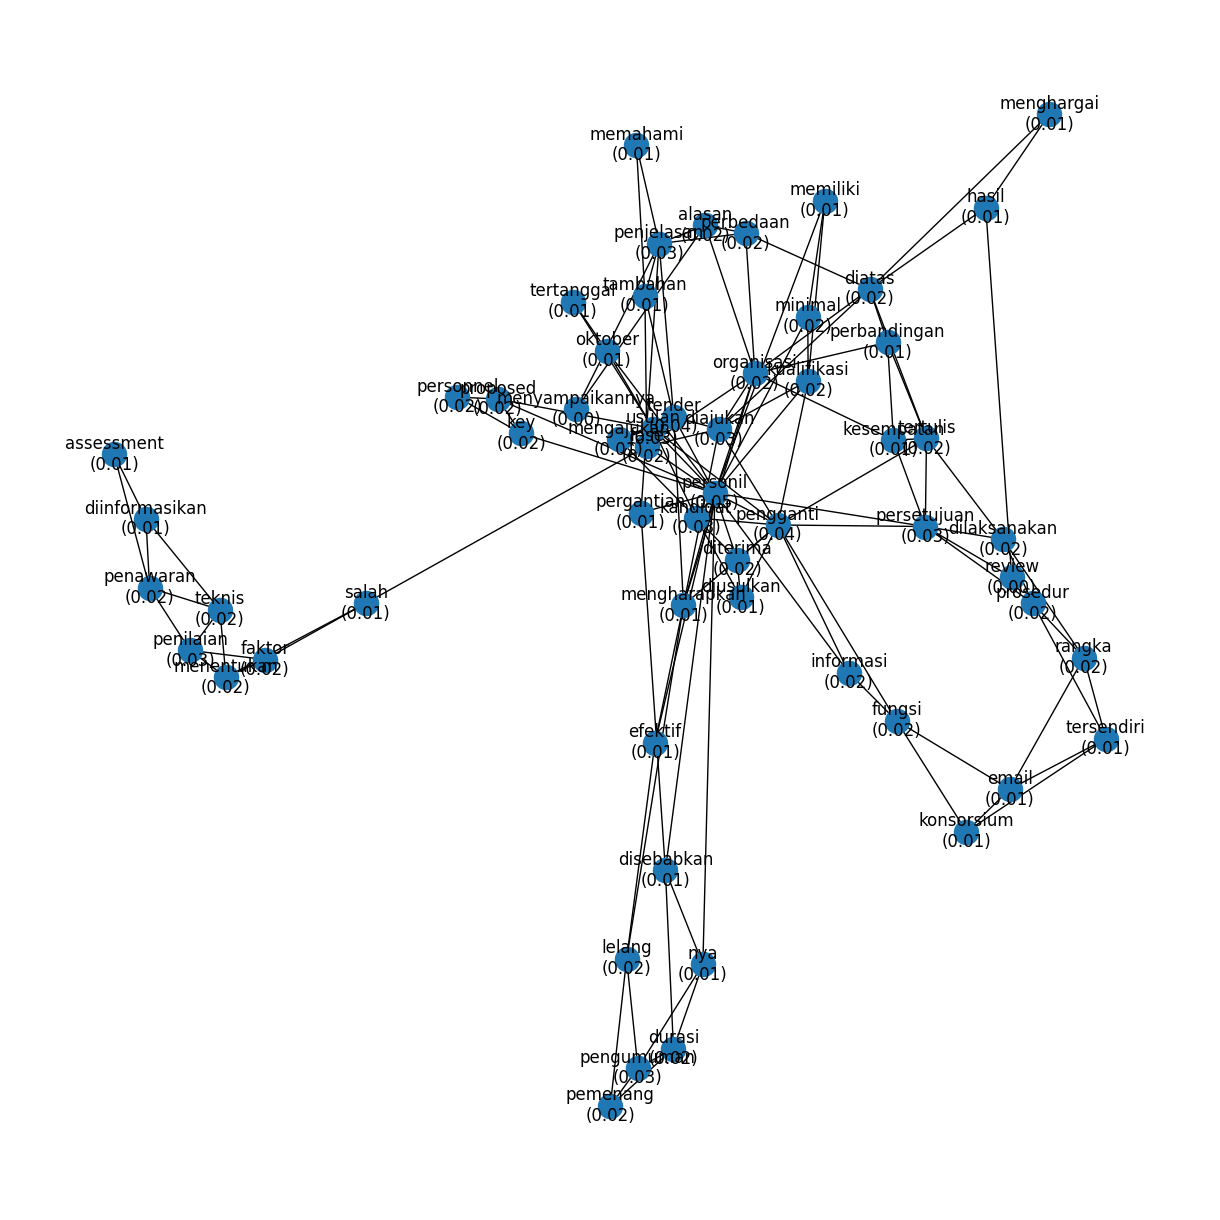

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

# Visualize the graph
visualize_graph(G, labels)


ITERASI UNTUK ALL DATA

In [22]:
predict_textrank = pd.DataFrame()
for i in df.index:
#for i in df.loc[:3].index:    
    print('Processing index', i, end='...! ')
    text = df["text"][i]
    keyphrases, labels = textrank(text, num_keywords=10)
    df_keyphrases = pd.DataFrame(keyphrases, columns=['Keyword', 'Score'])
    a = pd.DataFrame(df_keyphrases.Keyword).T.reset_index(drop=True)
    b = pd.DataFrame(df_keyphrases.Score).round(3).T.reset_index(drop=True)
    df_keyphrases = pd.concat([a, b], axis=1)

    # Check if there are missing columns and add them with zero values
    missing_columns = 20 - df_keyphrases.shape[1]
    for _ in range(missing_columns):
        df_keyphrases[df_keyphrases.shape[1]] = 0

    df_keyphrases.columns = ['key_1', 'key_2','key_3', 'key_4', 'key_5','key_6', 'key_7', 'key_8','key_9','key_10','score_1', 'score_2','score_3','score_4', 'score_5','score_6','score_7', 'score_8','score_9','score_10'] 
    predict_textrank = pd.concat([predict_textrank, df_keyphrases], ignore_index=True)
    print('Done')
predict_textrank.head(3)

Processing index 0...! Done
Processing index 1...! Done
Processing index 2...! Done
Processing index 3...! Done
Processing index 4...! Done
Processing index 5...! Done
Processing index 6...! Done
Processing index 7...! Done
Processing index 8...! Done
Processing index 9...! Done
Processing index 10...! Done
Processing index 11...! Done
Processing index 12...! Done
Processing index 13...! Done
Processing index 14...! Done
Processing index 15...! Done
Processing index 16...! Done
Processing index 17...! Done
Processing index 18...! Done
Processing index 19...! Done
Processing index 20...! Done
Processing index 21...! Done
Processing index 22...! Done
Processing index 23...! Done
Processing index 24...! Done
Processing index 25...! Done
Processing index 26...! Done
Processing index 27...! Done
Processing index 28...! Done
Processing index 29...! Done
Processing index 30...! Done
Processing index 31...! Done
Processing index 32...! Done
Processing index 33...! Done
Processing index 34...! 

,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,score_9,score_10
0,personil,pengganti,tender,penjelasan,persetujuan,penilaian,usulan,diajukan,kandidat,pengumuman,0.045,0.041,0.037,0.033,0.030,0.030,0.027,0.027,0.026,0.025
1,template,document,facilities,processing,procedure,coordination,pengelolaan,exhibit,acuan,tiung,0.105,0.102,0.097,0.095,0.087,0.079,0.065,0.064,0.062,0.057
2,kantor,ruangan,appendix,lapangan,kesepahaman,lokasi,usulan,klarifikasi,mingguan,offices,0.050,0.043,0.033,0.031,0.030,0.027,0.026,0.025,0.024,0.023


EVALUATION

In [23]:
from utils import eval

targets = df[["k1", "k2", "k3","k4", "k5", "k6","k7"]].values.tolist()
df_targets = pd.DataFrame(targets)

In [24]:
# Evaluation TextRank top 10
predict_textrank_list_10 = predict_textrank[['key_1','key_2','key_3', 'key_4','key_5','key_6', 'key_7','key_8','key_9', 'key_10']].values.tolist()
eval_textrank_10 = eval(predict_textrank_list_10, targets, True).round(3)
eval_textrank_10.columns = ['key_1','key_2','key_3', 'key_4','key_5','key_6', 'key_7','key_8','key_9', 'key_10','strict_recall', 'strict_prec', 'flex_recall','flex_prec']
eval_textrank_10 = eval_textrank_10[['key_1','key_2','key_3', 'key_4','key_5','key_6', 'key_7','key_8','key_9', 'key_10', 'flex_recall','flex_prec']] # untuk menyederhanakan hasil evaluasi
eval_textrank_10.head(3)

,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,flex_recall,flex_prec
0,no_match,full_match,no_match,no_match,partial_match,no_match,full_match,no_match,no_match,no_match,0.429,0.3
1,partial_match,partial_match,no_match,no_match,no_match,no_match,full_match,partial_match,full_match,no_match,0.714,0.5
2,partial_match,no_match,no_match,no_match,no_match,no_match,no_match,no_match,no_match,no_match,0.143,0.1


In [25]:
# Calculate TextRank Score, using flexible score : exact maatch =1, partial match = 1, no match = 0
textrank_recall_10 = eval_textrank_10['flex_recall'].mean()
textrank_prec_10 = eval_textrank_10['flex_prec'].mean()
textrank_f1_10 = 2 * (textrank_prec_10 * textrank_recall_10) / (textrank_prec_10 + textrank_recall_10)

# Create a DataFrame with the scores
summary_10 = pd.DataFrame({'textrank': [textrank_recall_10, textrank_prec_10, textrank_f1_10]}, index=['recall', 'precision', 'F1'])
summary_10 = summary_10.round(3)
summary_10

,textrank
recall,0.318
precision,0.223
F1,0.262


In [26]:
# Evaluation TextRank top 5
predict_textrank_list_5 = predict_textrank[['key_1','key_2','key_3', 'key_4','key_5']].values.tolist()
eval_textrank_5 = eval(predict_textrank_list_5, targets, True).round(3)
eval_textrank_5.columns = ['key_1','key_2','key_3', 'key_4','key_5','strict_recall', 'strict_prec', 'flex_recall','flex_prec']
eval_textrank_5 = eval_textrank_5[['key_1','key_2','key_3', 'key_4','key_5', 'flex_recall','flex_prec']] # untuk menyederhanakan hasil evaluasi
eval_textrank_5.head(3)

,key_1,key_2,key_3,key_4,key_5,flex_recall,flex_prec
0,no_match,full_match,no_match,no_match,partial_match,0.286,0.4
1,partial_match,partial_match,no_match,no_match,no_match,0.286,0.4
2,partial_match,no_match,no_match,no_match,no_match,0.143,0.2


In [27]:
# Calculate TextRank Score, using flexible score : exact maatch =1, partial match = 1, no match = 0
textrank_recall_5 = eval_textrank_5['flex_recall'].mean()
textrank_prec_5 = eval_textrank_5['flex_prec'].mean()
textrank_f1_5 = 2 * (textrank_prec_5 * textrank_recall_5) / (textrank_prec_5 + textrank_recall_5)

# Create a DataFrame with the scores
summary_5 = pd.DataFrame({'textrank': [textrank_recall_5, textrank_prec_5, textrank_f1_5]}, index=['recall', 'precision', 'F1'])
summary_5 = summary_5.round(3)
summary_5

,textrank
recall,0.217
precision,0.304
F1,0.254


In [28]:
# Evaluation TextRank top 3
predict_textrank_list_3 = predict_textrank[['key_1','key_2','key_3']].values.tolist()
eval_textrank_3 = eval(predict_textrank_list_3, targets, True).round(3)
eval_textrank_3.columns = ['key_1', 'key_2','key_3','strict_recall', 'strict_prec', 'flex_recall','flex_prec']
eval_textrank_3 = eval_textrank_3[['key_1', 'key_2','key_3', 'flex_recall','flex_prec']] # untuk menyederhanakan hasil evaluasi
eval_textrank_3.head(3)

,key_1,key_2,key_3,flex_recall,flex_prec
0,no_match,full_match,no_match,0.143,0.333
1,partial_match,partial_match,no_match,0.286,0.667
2,partial_match,no_match,no_match,0.143,0.333


In [29]:
# Calculate TextRank Score, using flexible score : exact maatch =1, partial match = 1, no match = 0
textrank_recall_3 = eval_textrank_3['flex_recall'].mean()
textrank_prec_3 = eval_textrank_3['flex_prec'].mean()
textrank_f1_3 = 2 * (textrank_prec_3 * textrank_recall_3) / (textrank_prec_3 + textrank_recall_3)

# Create a DataFrame with the scores
summary_3 = pd.DataFrame({'textrank': [textrank_recall_3, textrank_prec_3, textrank_f1_3]}, index=['recall', 'precision', 'F1'])
summary_3 = summary_3.round(3)
summary_3

,textrank
recall,0.156
precision,0.365
F1,0.219


In [30]:
# Combine dataframe predict_textrank, df_targets and eval_textrank
predict_textrank_10 = pd.concat([predict_textrank, df_targets, eval_textrank_10], axis=1)
predict_textrank_10.head(3)

,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,...,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,flex_recall,flex_prec
0,personil,pengganti,tender,penjelasan,persetujuan,penilaian,usulan,diajukan,kandidat,pengumuman,...,no_match,no_match,partial_match,no_match,full_match,no_match,no_match,no_match,0.429,0.3
1,template,document,facilities,processing,procedure,coordination,pengelolaan,exhibit,acuan,tiung,...,no_match,no_match,no_match,no_match,full_match,partial_match,full_match,no_match,0.714,0.5
2,kantor,ruangan,appendix,lapangan,kesepahaman,lokasi,usulan,klarifikasi,mingguan,offices,...,no_match,no_match,no_match,no_match,no_match,no_match,no_match,no_match,0.143,0.1


In [31]:
# Combine dataframe predict_textrank, df_targets and eval_textrank
predict_textrank_5 = pd.concat([predict_textrank, df_targets, eval_textrank_5], axis=1)
predict_textrank_5.head(3)

,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,...,4,5,6,key_1,key_2,key_3,key_4,key_5,flex_recall,flex_prec
0,personil,pengganti,tender,penjelasan,persetujuan,penilaian,usulan,diajukan,kandidat,pengumuman,...,NaN,NaN,NaN,no_match,full_match,no_match,no_match,partial_match,0.286,0.4
1,template,document,facilities,processing,procedure,coordination,pengelolaan,exhibit,acuan,tiung,...,dokumen,NaN,NaN,partial_match,partial_match,no_match,no_match,no_match,0.286,0.4
2,kantor,ruangan,appendix,lapangan,kesepahaman,lokasi,usulan,klarifikasi,mingguan,offices,...,services for company,exhibit a,NaN,partial_match,no_match,no_match,no_match,no_match,0.143,0.2


In [32]:
# Combine dataframe predict_textrank, df_targets and eval_textrank
predict_textrank_3 = pd.concat([predict_textrank, df_targets, eval_textrank_3], axis=1)
predict_textrank_3.head(3)

,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,...,2,3,4,5,6,key_1,key_2,key_3,flex_recall,flex_prec
0,personil,pengganti,tender,penjelasan,persetujuan,penilaian,usulan,diajukan,kandidat,pengumuman,...,usulan,pengganti,NaN,NaN,NaN,no_match,full_match,no_match,0.143,0.333
1,template,document,facilities,processing,procedure,coordination,pengelolaan,exhibit,acuan,tiung,...,acuan,pengelolaan,dokumen,NaN,NaN,partial_match,partial_match,no_match,0.286,0.667
2,kantor,ruangan,appendix,lapangan,kesepahaman,lokasi,usulan,klarifikasi,mingguan,offices,...,lingkup kerja,akomodasi,services for company,exhibit a,NaN,partial_match,no_match,no_match,0.143,0.333


In [33]:
import pandas as pd
from openpyxl import load_workbook

def write_excel(df, sheet_name, filename):
    """
    Writes the given dataframe to an excel file with the given filename and sheet name.
    If the sheet already exists in the file, the data in the sheet will be overwritten.
    """
    try:
        # Try to load the existing workbook
        with pd.ExcelWriter(filename, engine='openpyxl', mode='a') as writer:
            if sheet_name in writer.book.sheetnames:
                # If sheet already exists, remove it
                sheet = writer.book[sheet_name]
                writer.book.remove(sheet)

            # Write the dataframe to the excel file
            df.to_excel(writer, sheet_name=sheet_name, index=False)

    except FileNotFoundError:
        # If the file doesn't exist, create a new workbook
        with pd.ExcelWriter(filename, engine='openpyxl', mode='w') as writer:
            df.to_excel(writer, sheet_name=sheet_name, index=False)


In [34]:
# Write predictions to excel file
#from utils import write_excel

sheet_name_10 = 'SE3c_tr_phrase_pos_cooc_similar_10'
sheet_name_5 = 'SE3c_tr_phrase_pos_cooc_similar_5'
sheet_name_3 = 'SE3c_tr_phrase_pos_cooc_similar_3'

output_file = 'SE3c_tr_phrase_pos_cooc_similar.xlsx'
write_excel(predict_textrank_10, sheet_name_10, output_file)
write_excel(predict_textrank_5, sheet_name_5, output_file)
write_excel(predict_textrank_3, sheet_name_3, output_file)